In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Load mavenn and check path
import mavenn

# Import helper functions
from helper_functions import my_rsquared, save_fig_with_date_stamp, set_xticks

# Set random seed
np.random.seed(0)

# Set figure name
fig_name = 'fig3'

In [2]:
style_file_name = f'{fig_name}.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
title.size:         7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)


Bad key title.size in file fig3.style, line 4 ('title.size:         7.0')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# Load full GB1 model
gb1_additive_full_model = mavenn.load('../models/gb1_ge_additive_2021.12.30.21h.07m')

# load subsampled models 
subsampled_models = {}
for subsampled_double_mutants in [500, 5000, 50000]:
    file_name = f'../models/gb1_ge_additive_sub_{subsampled_double_mutants:d}_2021.12.30.21h.07m'
    subsampled_models[subsampled_double_mutants] =  mavenn.load(file_name)

Model loaded from these files:
	../models/gb1_ge_additive_2021.12.30.21h.07m.pickle
	../models/gb1_ge_additive_2021.12.30.21h.07m.h5
Model loaded from these files:
	../models/gb1_ge_additive_sub_500_2021.12.30.21h.07m.pickle
	../models/gb1_ge_additive_sub_500_2021.12.30.21h.07m.h5
Model loaded from these files:
	../models/gb1_ge_additive_sub_5000_2021.12.30.21h.07m.pickle
	../models/gb1_ge_additive_sub_5000_2021.12.30.21h.07m.h5
Model loaded from these files:
	../models/gb1_ge_additive_sub_50000_2021.12.30.21h.07m.pickle
	../models/gb1_ge_additive_sub_50000_2021.12.30.21h.07m.h5


In [4]:
# Load training data
data_df = pd.read_csv('../datasets/gb1_data.csv.gz')
trainval_df, test_df = mavenn.split_dataset(data_df)

# Get test x and y for 5000 randomly chosen points
ix = np.random.choice(a=len(test_df), size=5000, replace=False)
x_test = test_df['x'].values[ix]
y_test = test_df['y'].values[ix]

Training set   :  477,854 observations (  90.04%)
Validation set :   26,519 observations (   5.00%)
Test set       :   26,364 observations (   4.97%)
-------------------------------------------------
Total dataset  :  530,737 observations ( 100.00%)



In [5]:
# Compute lower bound on intrinsic information

# Load blackbox model
#model_bb = mavenn.load_example_model('gb1_ge_blackbox')
model_bb = mavenn.load('../models/gb1_ge_blackbox_2021.12.31.17h.31m')

# Compute blackbox predictive information
I_int_lb, dI_int_lb = model_bb.I_predictive(x_test, y_test)
print(f'I_int >= {I_int_lb:.4f} +- {dI_int_lb:.4f} bits')

Model loaded from these files:
	../models/gb1_ge_blackbox_2021.12.31.17h.31m.pickle
	../models/gb1_ge_blackbox_2021.12.31.17h.31m.h5
I_int >= 2.7407 +- 0.0135 bits


In [6]:
# Compute upper bound on intrinsic information
N = len(data_df)
c_s = data_df['selected_ct']
c_i = data_df['input_ct']

# Compute H_y and uncertainty therein
ys = np.log2((c_s+1)/(c_i+1))
ix = np.random.choice(a=N, size=20000, replace=False)
H_y, dH_y = mavenn.src.entropy.entropy_continuous(x=ys[ix], num_subsamples=100)

# Compute H_y_given_x and uncertainty therein
dys = np.log2(np.exp(1))*np.sqrt(1/(c_s+1) + 1/(c_i+1))
H_ys = 0.5*np.log2(2*np.pi*np.exp(1)*dys**2)
H_y_given_x = H_ys.mean()
dH_y_given_x = H_ys.std(ddof=1)/np.sqrt(N)

# Show resulting intrinsic information
I_int_ub = H_y - H_ys.mean()
dI_int_ub = np.sqrt(dH_y**2 + dH_y_given_x**2)
print(f'I_int <= {I_int_ub:.4f} +- {dI_int_ub:.4f} bits')

I_int <= 3.2146 +- 0.0066 bits


In [7]:
# Load model contents
alphabet = gb1_additive_full_model.alphabet
L = gb1_additive_full_model.L
wt_seq = gb1_additive_full_model.x_stats['consensus_seq']
theta_lc = gb1_additive_full_model.get_theta(gauge='consensus')['theta_lc']

# Compute test phi and yhat for panel b
phi_b = gb1_additive_full_model.x_to_phi(x_test)
yhat_test_b = gb1_additive_full_model.phi_to_yhat(phi_b)

# Compute grid values for panel b
phi_lim = [-5,4]
phi_grid_b = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid_b = gb1_additive_full_model.phi_to_yhat(phi_grid_b)
yq_grid_b = gb1_additive_full_model.yhat_to_yq(yhat_grid_b, q=[.025, .975])

# Compute wt seq values
phi_wt_full = gb1_additive_full_model.x_to_phi(wt_seq)
yhat_c = yhat_test_b
yhat_wt_full = gb1_additive_full_model.x_to_yhat(wt_seq)

# Get trianing history
train_I_var_d = gb1_additive_full_model.history['I_var']

# Compute information metrics
I_var, dI_var =  gb1_additive_full_model.I_variational(x=x_test, y=y_test)
I_pred, dI_pred = gb1_additive_full_model.I_predictive(x=x_test, y=y_test)

In [8]:
# Get indices for aa order used in Olson et al.
ordered_aa = np.array(list('EDRKHQNSTPGCAVILMFYW'))
ix = ordered_aa.argsort()
sorted_aa = ordered_aa[ix]
ixx = ix.argsort()
alphabet[ixx]

array(['E', 'D', 'R', 'K', 'H', 'Q', 'N', 'S', 'T', 'P', 'G', 'C', 'A',
       'V', 'I', 'L', 'M', 'F', 'Y', 'W'], dtype='<U1')

Figure saved figure to png/fig3_ipynb_2022.03.18.08h.28m.20s.png.


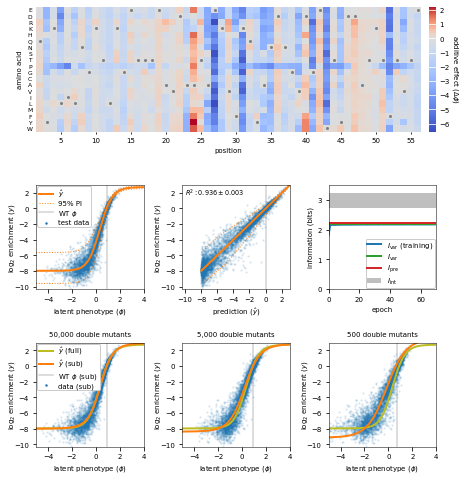

In [11]:
# Draw figure
fig = plt.figure(figsize=[6.5, 6.7])
gs = fig.add_gridspec(3, 3, height_ratios=[1.2,1,1])

# Set lims and ticks
ylim = [-10.3, 3] 
yticks = [-10,-8,-6,-4,-2,0,2]
phi_ticks = [-4,-2,0,2,4]
I_lim = [0, 3.5]
I_ticks = [0,1,2,3]

# Define panels
ax_a = fig.add_subplot(gs[0, :])
ax_b = fig.add_subplot(gs[1, 0])
ax_c = fig.add_subplot(gs[1, 1])
ax_d = fig.add_subplot(gs[1, 2])
ax_e = fig.add_subplot(gs[2, 0])
ax_f = fig.add_subplot(gs[2, 1])
ax_g = fig.add_subplot(gs[2, 2])


#
# Panel A: Heatmap
#
ax = ax_a

# Draw heatmap
ax, cb = mavenn.heatmap(theta_lc[:,ixx], 
                        alphabet[ixx],
                        ax=ax, 
                        seq=wt_seq, 
                        seq_kwargs={'s':4, 'color':'gray'},
                        ccenter=0,
                        #clim=[-1,1],
                        cmap_size="2%",
                        cmap='coolwarm')

# Style axes
set_xticks(ax=ax, L=L, pos_start=2, pos_spacing=5)
ax.set_ylabel('amino acid')
ax.set_xlabel('position')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(rotation=0, size=2)
ax.tick_params(axis='y', size=0, pad=6, labelsize=6)

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=10, color='white')
#cb.set_ticks([-1,-.5,0,.5,1])
cb.set_label('additive effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')


#
# Panel B: GE plot
#
ax = ax_b

# Draw GE scatter
ax.scatter(phi_b, 
           y_test, 
           s=2,
           alpha=.1,
           label='test data',
           color='C0')

# Draw GE curves
ax.plot(phi_grid_b, yhat_grid_b,    color='C1', alpha=1, linewidth=2, linestyle='-', label='$\hat{y}$')
ax.plot(phi_grid_b, yq_grid_b[:,0], color='C1', linestyle=':', linewidth=1,  label='95% PI')
ax.plot(phi_grid_b, yq_grid_b[:,1], color='C1', linestyle=':', linewidth=1)

# Draw wt phi
ax.axvline(phi_wt_full, color='lightgray', zorder=-1, label='WT $\phi$')

# Style axes
ax.set_xticks(phi_ticks)
ax.set_yticks(yticks)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('$\log_2$ enrichment ($y$)', labelpad=-3)
ax.set_xlim(phi_lim)
ax.set_ylim(ylim)

# ax.legend()
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

    
#
# Panel C: Scatter plot
#
ax = ax_c
xlim = [min(yhat_c), ylim[1]]

# Draw GE scatter
ax.scatter(yhat_c, 
           y_test, 
           s=2,
           label='test data',
           alpha=.1,
           color='C0')

# Draw diagonal and CIs
ax.plot(xlim, xlim, linestyle='-', color='C1', linewidth=2, label='$\hat{y}$')
ax.plot(yhat_grid_b, yq_grid_b[:,0], linestyle=':', color='C1', linewidth=1, label='95% PI')
ax.plot(yhat_grid_b, yq_grid_b[:,1], linestyle=':', color='C1', linewidth=1)

# Draw wt phi
ax.axvline(yhat_wt_full, color='lightgray', zorder=-1)

# Style plot
ax.set_xticks(yticks)
ax.set_yticks(yticks)
ax.set_xlabel('prediction ($\hat{y}$)')
ax.set_ylabel('$\log_2$ enrichment ($y$)', labelpad=-3)
ax.set_xlim(ylim)
ax.set_ylim(ylim)

# Compute and show R^2
r2, dr2 = my_rsquared(yhat_c, y_test)
ax.text(x=-10, y=2, s=f'$R^2: {r2:.3f} \pm {dr2:.3f}$', ha='left', va='center', fontsize=6.5)


#
# Panel D: Training plot
#
ax = ax_d

# Plot training I_var
epochs = np.arange(len(train_I_var_d))
ax.plot(epochs, train_I_var_d, '-', label='$I_\mathrm{var}$ (training)', color='C0', linewidth=2)

# Draw information lines
xlim = [0, max(epochs)]
ax.axhline(I_var,  label='$I_\mathrm{{var}}$', color='C2', linestyle='-', linewidth=2, alpha=1)
ax.axhline(I_pred, label='$I_\mathrm{{pre}}$', color='C3', linestyle='-', linewidth=2, alpha=1)

# Draw intrinsic information area
ax.fill_between(xlim, 
                [I_int_ub, I_int_ub], 
                [I_int_lb, I_int_lb], 
                linewidth=0,
                color='gray', 
                alpha=.5, 
                zorder=-100, 
                label='$I_\mathrm{int}$')

# Style plot
ax.set_ylim(I_lim)
ax.set_yticks(I_ticks)
ax.set_xlim(xlim)
ax.set_xlabel('epoch')
ax.set_ylabel('information (bits)', labelpad=3)
ax.legend(loc='lower right')


#
# Panels E, F, G: Subsampled models
#

# Function to draw panels for subsampled models
def draw(ax, model_s, legend_loc=None):
    model = subsampled_models[model_s]
    phi = model.x_to_phi(x_test)
    yhat= model.x_to_yhat(x_test)
    
    # Create grid yhat
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
    yhat_grid = model.phi_to_yhat(phi_grid)

    # Show scatter
    ax.scatter(phi, y_test, color='C0', s=2, alpha=.1, label='data (sub)')
    
    # Plot curve from panel b
    ax.plot(phi_grid_b, yhat_grid_b, linewidth=2, color='C8', label='$\hat{y}$ (full)')
    
    # Plot curve for subsampled model
    ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
            label='$\hat{y}$ (sub)')

    # Draw wt phi
    phi_wt_sub = model.x_to_phi(wt_seq)
    ax.axvline(phi_wt_sub, color='lightgray', zorder=-1, label='WT $\phi$ (sub)')
    
    # Style plot
    ax.set_xlim(phi_lim)
    ax.set_xlabel('latent phenotype ($\phi$)')
    ax.set_ylabel('$\log_2$ enrichment ($y$)', labelpad=-3)
    ax.set_title(f'{model_s:,d} double mutants', fontsize=7)
    ax.set_xticks(phi_ticks)
    ax.set_yticks(yticks)
    ax.set_ylim(ylim)
    
    if legend_loc:      
        leg = ax.legend(loc=legend_loc)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            
# Draw panels with subsampled models
draw(ax=ax_e, model_s=50000, legend_loc='upper left')
draw(ax=ax_f, model_s=5000)
draw(ax=ax_g, model_s=500)

# Tight layout
fig.tight_layout(h_pad=2)
            
# Save figure
save_fig_with_date_stamp(fig, fig_name)

In [10]:
# Repeat information metrics
print(f'I_var = {I_var:.3f} +- {dI_var:.3f} bits')
print(f'I_pred = {I_pred:.3f} +- {dI_pred:.3f} bits')
print(f'I_int >= {I_int_lb:.3f} +- {dI_int_lb:.3f} bits')
print(f'I_int <= {I_int_ub:.3f} +- {dI_int_ub:.3f} bits')

I_var = 2.178 +- 0.027 bits
I_pred = 2.225 +- 0.017 bits
I_int >= 2.741 +- 0.013 bits
I_int <= 3.215 +- 0.007 bits
